# YouTube QoE

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intrig-unicamp/hackathon5G/blob/main/datasets/youtube-qoe.ipynb)

Esse Notebook contém uma breve análise dos dados que o YouTube coleta para telemetria dos seus clientes (Web Desktop, Web Mobile, IFrame API, App). O usuário é encorajado a experimentar com os dados para descobrir padrões, formas de resolver problemas no contexto da Hackathon.

Os dados utilizados nesse Notebook foram extraídos a partir de coletas usando [`PCAPdroid`](https://github.com/emanuele-f/PCAPdroid) + [`PCAPdroid-mitm addon`](https://github.com/emanuele-f/PCAPdroid-mitm) (Android) e `Chrome DevTools` (Desktop), que resultam em arquivos `PCAP` e `HAR`, respectivamente.

## Instalação das dependências

Descomente a célula mágica abaixo para instalar as dependências no ambiente adequado (pip ou Anaconda).

In [22]:
%pip install pyshark -q

In [23]:
#%conda install pyshark -q

Descomente a célula mágica abaixo para instalar as dependências usando o gerenciador de pacotes de sistema adequado (`apt-get` - Google Colab/Debian/Ubuntu, `apk` - Alpine, `yum` - RHEL/CentOS/Fedora, `pacman` - Arch, `nix-env`).

In [24]:
!apt-get install tshark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tshark is already the newest version (3.2.3-1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [25]:
#!yum install tshark

In [26]:
#!apk add tshark

In [27]:
#!pacman -S tshark

In [28]:
#!nix-env -iA nixpkgs.tshark

## Importando dependências globais

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
from urllib.parse import urlparse, parse_qsl

try:
    import google.colab as _
    IN_COLAB = True
except:
    IN_COLAB = False

## PCAP

In [30]:
import pyshark

# https://github.com/KimiNewt/pyshark/issues/360#issuecomment-700425352
import nest_asyncio
nest_asyncio.apply()

In [31]:
if IN_COLAB:
    !gdown 1eoOuQ3jiZ_yULQJK2UpYkZVAbPka4r5n

PCAP_FILENAME = './PCAPdroid_17_Feb_02_19_56.pcapng'

Downloading...
From: https://drive.google.com/uc?id=1eoOuQ3jiZ_yULQJK2UpYkZVAbPka4r5n
To: /content/PCAPdroid_17_Feb_02_19_56.pcapng
100% 16.6M/16.6M [00:00<00:00, 209MB/s]


In [32]:
def open_youtube_qoe_pcap(pcap_filename):
    return pyshark.FileCapture(input_file=pcap_filename, display_filter='http2.header.value contains "api/stats/qoe"')

In [33]:
pcap = open_youtube_qoe_pcap(PCAP_FILENAME)
packet = pcap[0]
packet.http2.field_names

['stream',
 'length',
 'type',
 'flags',
 'flags_end_stream',
 'flags_eh',
 'flags_padded',
 'flags_priority',
 'flags_unused_headers',
 'r',
 'streamid',
 'pad_length',
 'exclusive',
 'stream_dependency',
 'headers_weight',
 'headers_weight_real',
 'headers',
 'header_length',
 'header_count',
 'header',
 'header_name_length',
 'header_name',
 'header_value_length',
 'header_value',
 'headers_method',
 'header_unescaped',
 'header_repr',
 'header_index',
 'headers_authority',
 'headers_scheme',
 'headers_path',
 'headers_content_length',
 'headers_user_agent',
 'headers_content_type',
 'headers_accept',
 'headers_referer',
 'headers_accept_encoding',
 'headers_accept_language',
 'headers_cookie']

In [34]:
packet.http2.headers_path

'/api/stats/qoe?fmt=243&afmt=251&cpn=oMaRrct9XOA6WR0D&el=detailpage&ns=yt&fexp=23848211%2C23983296%2C24004644%2C24007246%2C24080738%2C24135310%2C24169501%2C24255165%2C24288346%2C24396647%2C24415864%2C24439360%2C24450367%2C24451033%2C24451438%2C24455613%2C24458634%2C24467965%2C24475438%2C24476238%2C39323075&cl=509820939&seq=1&docid=d5r-kEmQfBg&ei=gA7vY83zJeyPobIPq_OcmAg&event=streamingstats&plid=AAX03ncKwXUwJiIT&cbrand=samsung&cbr=Chrome%20Mobile&cbrver=109.0.0.0&c=MWEB&cver=2.20230215.10.00&cplayer=UNIPLAYER&cmodel=sm-g991b&cos=Android&cosver=13&cplatform=MOBILE&vps=0.000:N,0.008:N&afs=0.008:251::i&vfs=0.008:243:243::d&view=0.008:360:203:3&bwe=0.008:752419&vis=0.008:0&cmt=0.008:0.000&conn=0.008:1&bh=0.008:0.000'

In [64]:
def extract_youtube_qoe_urls_from_pcap(pcap):
    data = []
    for each in pcap:
        data.append(each.http2.headers_path)
    return data

In [65]:
api_stats_qoe = extract_youtube_qoe_urls_from_pcap(pcap)
len(api_stats_qoe)

12

## HAR

In [66]:
import json

In [67]:
if IN_COLAB:
    !gdown 1qUA3b-QEhBSBzOe8D9dMU7gAQehO9OdZ

HAR_FILENAME = './www.youtube.com.har'

Downloading...
From: https://drive.google.com/uc?id=1qUA3b-QEhBSBzOe8D9dMU7gAQehO9OdZ
To: /content/www.youtube.com.har
100% 129M/129M [00:00<00:00, 278MB/s]


In [68]:
with open(HAR_FILENAME, 'r') as f:
    har = json.load(f)

In [69]:
har['log']['entries'][0]['request']['url']

'https://www.youtube.com/api/stats/qoe?fmt=271&afmt=251&cpn=rK3BMYUZSURO9KBY&el=detailpage&ns=yt&fexp=23858057%2C23983296%2C23986023%2C24004644%2C24007246%2C24080738%2C24135310%2C24169501%2C24219381%2C24255163%2C24396645%2C24411033%2C24415864%2C24416439%2C24421858%2C24433679%2C24437577%2C24439361%2C24449112%2C24450366%2C24451032%2C24457275&cl=501313814&seq=62&docid=bTpKM43VhwA&ei=UvbVY5i5EP6a1sQPiI2h-AU&event=streamingstats&feature=g-high&osid=AAAAAKkd2C8%3AAOeUNAavuQSN72LSYVoMExbkkTijt_yJvA&plid=AAXzX43RrsfOjzaS&referrer=https%3A%2F%2Fwww.youtube.com%2Ffeed%2Fsubscriptions&sdetail=p%3A%2Ffeed%2Fsubscriptions&sourceid=y&cbr=Chrome&cbrver=108.0.0.0&c=WEB&cver=2.20230126.08.00&cplayer=UNIPLAYER&cos=X11&cplatform=DESKTOP&vps=3301.984:PA&bwe=3301.984:8195200&bat=3301.984:1:1&cmt=3301.984:939.766&bh=3301.984:993.392'

In [70]:
def extract_youtube_qoe_urls_from_har(har):
    data = []
    for each in har['log']['entries']:
        url = each['request']['url']
        if 'youtube.com/api/stats/qoe?' in url:
            data.append(url)
    return data

In [71]:
api_stats_qoe = extract_youtube_qoe_urls_from_har(har)
len(api_stats_qoe)

45

## Extraindo as métricas de QoE do YouTube das URLs capturadas

In [72]:
url = api_stats_qoe[10]
url

'https://www.youtube.com/api/stats/qoe?fmt=271&afmt=251&cpn=lNl65JkWfbrigP2A&el=detailpage&ns=yt&fexp=23858057%2C23983296%2C23986023%2C24004644%2C24007246%2C24080738%2C24135310%2C24169501%2C24219381%2C24255163%2C24396645%2C24411033%2C24415864%2C24416439%2C24421858%2C24433679%2C24437577%2C24439361%2C24449112%2C24450366%2C24451032%2C24457275&cl=501313814&seq=10&docid=bTpKM43VhwA&ei=OAPWY7HkLMTJwgTWj6PgBQ&event=streamingstats&osid=AAAAAKkd2C8%3AAOeUNAavuQSN72LSYVoMExbkkTijt_yJvA&plid=AAXzYFKprfJNv5aY&referrer=https%3A%2F%2Fwww.youtube.com%2Ffeed%2Fsubscriptions&sdetail=p%3A%2Ffeed%2Fsubscriptions&sourceid=y&cbr=Chrome&cbrver=108.0.0.0&c=WEB&cver=2.20230126.08.00&cplayer=UNIPLAYER&cos=X11&cplatform=DESKTOP&vps=210.008:PL&bwm=210.008:19869029:2.012&bwe=210.008:9549843&bat=210.008:1:1&cmt=210.008:478.221&bh=210.008:41.717'

In [73]:
url_parts = urlparse(url)
url_parts

ParseResult(scheme='https', netloc='www.youtube.com', path='/api/stats/qoe', params='', query='fmt=271&afmt=251&cpn=lNl65JkWfbrigP2A&el=detailpage&ns=yt&fexp=23858057%2C23983296%2C23986023%2C24004644%2C24007246%2C24080738%2C24135310%2C24169501%2C24219381%2C24255163%2C24396645%2C24411033%2C24415864%2C24416439%2C24421858%2C24433679%2C24437577%2C24439361%2C24449112%2C24450366%2C24451032%2C24457275&cl=501313814&seq=10&docid=bTpKM43VhwA&ei=OAPWY7HkLMTJwgTWj6PgBQ&event=streamingstats&osid=AAAAAKkd2C8%3AAOeUNAavuQSN72LSYVoMExbkkTijt_yJvA&plid=AAXzYFKprfJNv5aY&referrer=https%3A%2F%2Fwww.youtube.com%2Ffeed%2Fsubscriptions&sdetail=p%3A%2Ffeed%2Fsubscriptions&sourceid=y&cbr=Chrome&cbrver=108.0.0.0&c=WEB&cver=2.20230126.08.00&cplayer=UNIPLAYER&cos=X11&cplatform=DESKTOP&vps=210.008:PL&bwm=210.008:19869029:2.012&bwe=210.008:9549843&bat=210.008:1:1&cmt=210.008:478.221&bh=210.008:41.717', fragment='')

In [74]:
url_query_params_tuples = parse_qsl(url_parts.query)
url_query_params_tuples

[('fmt', '271'),
 ('afmt', '251'),
 ('cpn', 'lNl65JkWfbrigP2A'),
 ('el', 'detailpage'),
 ('ns', 'yt'),
 ('fexp',
  '23858057,23983296,23986023,24004644,24007246,24080738,24135310,24169501,24219381,24255163,24396645,24411033,24415864,24416439,24421858,24433679,24437577,24439361,24449112,24450366,24451032,24457275'),
 ('cl', '501313814'),
 ('seq', '10'),
 ('docid', 'bTpKM43VhwA'),
 ('ei', 'OAPWY7HkLMTJwgTWj6PgBQ'),
 ('event', 'streamingstats'),
 ('osid', 'AAAAAKkd2C8:AOeUNAavuQSN72LSYVoMExbkkTijt_yJvA'),
 ('plid', 'AAXzYFKprfJNv5aY'),
 ('referrer', 'https://www.youtube.com/feed/subscriptions'),
 ('sdetail', 'p:/feed/subscriptions'),
 ('sourceid', 'y'),
 ('cbr', 'Chrome'),
 ('cbrver', '108.0.0.0'),
 ('c', 'WEB'),
 ('cver', '2.20230126.08.00'),
 ('cplayer', 'UNIPLAYER'),
 ('cos', 'X11'),
 ('cplatform', 'DESKTOP'),
 ('vps', '210.008:PL'),
 ('bwm', '210.008:19869029:2.012'),
 ('bwe', '210.008:9549843'),
 ('bat', '210.008:1:1'),
 ('cmt', '210.008:478.221'),
 ('bh', '210.008:41.717')]

In [75]:
url_query_params_dict = { k: v for k, v in url_query_params_tuples }
url_query_params_dict

{'fmt': '271',
 'afmt': '251',
 'cpn': 'lNl65JkWfbrigP2A',
 'el': 'detailpage',
 'ns': 'yt',
 'fexp': '23858057,23983296,23986023,24004644,24007246,24080738,24135310,24169501,24219381,24255163,24396645,24411033,24415864,24416439,24421858,24433679,24437577,24439361,24449112,24450366,24451032,24457275',
 'cl': '501313814',
 'seq': '10',
 'docid': 'bTpKM43VhwA',
 'ei': 'OAPWY7HkLMTJwgTWj6PgBQ',
 'event': 'streamingstats',
 'osid': 'AAAAAKkd2C8:AOeUNAavuQSN72LSYVoMExbkkTijt_yJvA',
 'plid': 'AAXzYFKprfJNv5aY',
 'referrer': 'https://www.youtube.com/feed/subscriptions',
 'sdetail': 'p:/feed/subscriptions',
 'sourceid': 'y',
 'cbr': 'Chrome',
 'cbrver': '108.0.0.0',
 'c': 'WEB',
 'cver': '2.20230126.08.00',
 'cplayer': 'UNIPLAYER',
 'cos': 'X11',
 'cplatform': 'DESKTOP',
 'vps': '210.008:PL',
 'bwm': '210.008:19869029:2.012',
 'bwe': '210.008:9549843',
 'bat': '210.008:1:1',
 'cmt': '210.008:478.221',
 'bh': '210.008:41.717'}

In [76]:
def ft_comma_separated(value_type):
    def inner(value):
        value = [ e for e in value.split(',') ]
        value = [ value_type(v) for v in value ]
        return value
    return inner

def ft_comma_separated_ts(value_type):
    def inner(value):
        value = [ e.split(':') for e in value.split(',') ]
        value = [ { 'at': float(at), **value_type(*v) } for at, *v in value ]
        return value
    return inner

def youtube_qoe_field_transform(field, value):
    # https://developers.google.com/youtube/iframe_api_reference#getPlayerState
    player_state_enum_map = {
        'N':  'unstarted/cued', # -1 = unstarted; 5 = video cued
        'EN': 'ended',   # 0
        'PL': 'playing', # 1
        'PA': 'paused',  # 2
        'B':  'buffering', # 3
        'S':  'seek',    # guess based on player interactions
    }
    fields_transformers = {
        #'seq':   ft_identity(lambda  v: { 'value': int(v) }),
        #'event': ft_identity(lambda  v: { 'value': str(v) }),
        'cmt':   ft_comma_separated_ts(lambda  v: { 'value': float(v) }),
        'vps':   ft_comma_separated_ts(lambda  v: { 'value': player_state_enum_map.get(v, v)   }),
        'bh':    ft_comma_separated_ts(lambda  v: { 'value': float(v) }),
        'bwe':   ft_comma_separated_ts(lambda  v: { 'value': int(v)   }),
        'bwm':   ft_comma_separated_ts(lambda *v: { 'downloaded_bytes': int(v[0]), 'seconds_to_download': float(v[1]) }),
        'bat':   ft_comma_separated_ts(lambda *v: { 'percentage': float(v[0]) * 100, 'is_charging': v[1] == '1' }),
        'view':  ft_comma_separated_ts(lambda *v: { 'width': int(v[0]), 'height': int(v[1]) }),
        'df':    ft_comma_separated_ts(lambda  v: { 'value': int(v)   }),
    }

    if field not in fields_transformers:
        return value

    return fields_transformers[field](value)

In [77]:
url_query_params_dict_transform = { k: youtube_qoe_field_transform(k, v) for k, v in url_query_params_dict.items() }
url_query_params_dict_transform

{'fmt': '271',
 'afmt': '251',
 'cpn': 'lNl65JkWfbrigP2A',
 'el': 'detailpage',
 'ns': 'yt',
 'fexp': '23858057,23983296,23986023,24004644,24007246,24080738,24135310,24169501,24219381,24255163,24396645,24411033,24415864,24416439,24421858,24433679,24437577,24439361,24449112,24450366,24451032,24457275',
 'cl': '501313814',
 'seq': '10',
 'docid': 'bTpKM43VhwA',
 'ei': 'OAPWY7HkLMTJwgTWj6PgBQ',
 'event': 'streamingstats',
 'osid': 'AAAAAKkd2C8:AOeUNAavuQSN72LSYVoMExbkkTijt_yJvA',
 'plid': 'AAXzYFKprfJNv5aY',
 'referrer': 'https://www.youtube.com/feed/subscriptions',
 'sdetail': 'p:/feed/subscriptions',
 'sourceid': 'y',
 'cbr': 'Chrome',
 'cbrver': '108.0.0.0',
 'c': 'WEB',
 'cver': '2.20230126.08.00',
 'cplayer': 'UNIPLAYER',
 'cos': 'X11',
 'cplatform': 'DESKTOP',
 'vps': [{'at': 210.008, 'value': 'playing'}],
 'bwm': [{'at': 210.008,
   'downloaded_bytes': 19869029,
   'seconds_to_download': 2.012}],
 'bwe': [{'at': 210.008, 'value': 9549843}],
 'bat': [{'at': 210.008, 'percentage': 10

In [78]:
def extract_youtube_qoe_metrics_from_urls(urls):
    urls = [ { k: v for k, v in parse_qsl(urlparse(i).query) } for i in urls ]
    urls = [ { k: youtube_qoe_field_transform(k, v) for k, v in i.items() } for i in urls ]
    return urls

In [79]:
api_stats_qoe = extract_youtube_qoe_metrics_from_urls(api_stats_qoe)
len(api_stats_qoe)

45

## Colunas

- **Identifiers**
    - `docid`: video identifier, as in URL
    - `event`: event type (always "streamingstats")
    - `cpn` (client playback nonce): unique identifier for the playback. equivalent to sCPN shown in stats for nerds
    - `seq` (sequence): sequence number of the QoE sample
    - `ei`: eventId
    - `fexp`: experimentIds

- **Player environment**
    - `c` (client): WEB_EMBEDDED_PLAYER | WEB
    - `el` (event label): detailpage | adunit | embedded | embedded_unbranded | shortspage (TO BE CONFIRMED)

- **Player**
    - `view` (view size, getPlayerSize/getSize): the timestamp, width, and height of the player size at that timestamp
    - `vps` (video player state, getPlayerState): the timestamp and the state of the video at that timestamp (N/-1: unstarted, EN/0: ended, PL/1: playing, PA/2: paused, B/3: buffering, N/5: video cued)
    - `vis` (visibility status, getVisibilityState): which includes the time and the video visibility state (enum unknown)

- **Buffer**
    - `bh` (on site: Buffer Health; on app: Readahead): the timestamp and the buffer health at that timestamp (represented in seconds)
    - `df` (dropped frames; on site: Viewport / Frames: W:H / x dropped of X; on app: Framedrop: x fps): the timestamp and the number of dropped frames

- **Connection speed**
    - `bwe` (bandwidth estimation; on site: Connection Speed on app: Conn Speed): the timestamp and the estimated bandwidth in bytes at that timestamp
    - `bwm` (bandwidth measurement; on site: Network Activity; on app: Net Activity): the timestamp, the downloaded bytes of audio and video (from *.googlevideo.com/videoplayback), the time took for download

- **Device**
    - `bat` (battery): the timestamp, charged percentage, charging

- `cmt` (client measurement time, getCurrentTime): the timestamp and the corresponding video position (in seconds)


Colunas ainda não identificadas:
- `fmt` (video format/codec): TODO - map to actual video format/resolution instead of an identifier
- `afmt` (audio format/codec): TODO - map to actual audio format/quality instead of an identifier
- `vfs` (video ...)
- `afs` (audio ...)
- `ctmp`
- `stream`
- `user_intent`
- `dt`
- `ns`
- `cl`
- `osid`
- `plid`

## Exploração

In [80]:
for i in api_stats_qoe:
    f = 'view'
    if f in  i: print(i[f])

[{'at': 0.007, 'width': 875, 'height': 480}]
[{'at': 937.749, 'width': 875, 'height': 480}]
[{'at': 1090.447, 'width': 875, 'height': 480}]
[{'at': 1101.26, 'width': 875, 'height': 480}]
[{'at': 1187.527, 'width': 875, 'height': 480}]
[{'at': 1196.286, 'width': 875, 'height': 480}]
[{'at': 1205.341, 'width': 875, 'height': 480}]
[{'at': 1215.828, 'width': 875, 'height': 480}]


In [81]:
qoe_df = pd.DataFrame(api_stats_qoe)
qoe_df.columns
#qoe_df.qoealert.unique()

Index(['fmt', 'afmt', 'cpn', 'el', 'ns', 'fexp', 'cl', 'seq', 'docid', 'ei',
       'event', 'feature', 'osid', 'plid', 'referrer', 'sdetail', 'sourceid',
       'cbr', 'cbrver', 'c', 'cver', 'cplayer', 'cos', 'cplatform', 'vps',
       'bwe', 'bat', 'cmt', 'bh', 'afs', 'vfs', 'view', 'vis', 'stream',
       'user_intent', 'ctmp', 'bwm', 'df', 'qoealert'],
      dtype='object')

In [82]:
qoe_df = pd.json_normalize(api_stats_qoe, sep='.')
qoe_df

,fmt,afmt,cpn,el,ns,fexp,cl,seq,docid,ei,...,afs,vfs,view,vis,stream,user_intent,ctmp,bwm,df,qoealert
0,271,251,rK3BMYUZSURO9KBY,detailpage,yt,"23858057,23983296,23986023,24004644,24007246,2...",501313814,62,bTpKM43VhwA,UvbVY5i5EP6a1sQPiI2h-AU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,271,251,lNl65JkWfbrigP2A,detailpage,yt,"23858057,23983296,23986023,24004644,24007246,2...",501313814,1,bTpKM43VhwA,OAPWY7HkLMTJwgTWj6PgBQ,...,0.007:251::i,0.007:271:400::s,"[{'at': 0.007, 'width': 875, 'height': 480}]",0.007:0,NaN,NaN,NaN,NaN,NaN,NaN
2,271,251,lNl65JkWfbrigP2A,detailpage,yt,"23858057,23983296,23986023,24004644,24007246,2...",501313814,2,bTpKM43VhwA,OAPWY7HkLMTJwgTWj6PgBQ,...,NaN,NaN,NaN,NaN,1.129:A,0,sfn:,"[{'at': 10.004, 'downloaded_bytes': 17592070, ...","[{'at': 10.004, 'value': 0}]",NaN
3,271,251,lNl65JkWfbrigP2A,detailpage,yt,"23858057,23983296,23986023,24004644,24007246,2...",501313814,3,bTpKM43VhwA,OAPWY7HkLMTJwgTWj6PgBQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'at': 40.004, 'downloaded_bytes': 29717370, ...",NaN,NaN
4,271,251,lNl65JkWfbrigP2A,detailpage,yt,"23858057,23983296,23986023,24004644,24007246,2...",501313814,4,bTpKM43VhwA,OAPWY7HkLMTJwgTWj6PgBQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'at': 70.004, 'downloaded_bytes': 30809196, ...","[{'at': 70.004, 'value': 2}]",NaN
5,271,251,lNl65JkWfbrigP2A,detailpage,yt,"23858057,23983296,23986023,24004644,24007246,2...",501313814,5,bTpKM43VhwA,OAPWY7HkLMTJwgTWj6PgBQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'at': 78.598, 'downloaded_bytes': 3385309, '...",NaN,NaN
6,271,251,lNl65JkWfbrigP2A,detailpage,yt,"23858057,23983296,23986023,24004644,24007246,2...",501313814,6,bTpKM43VhwA,OAPWY7HkLMTJwgTWj6PgBQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'at': 110.005, 'downloaded_bytes': 25647276,...",NaN,NaN
7,271,251,lNl65JkWfbrigP2A,detailpage,yt,"23858057,23983296,23986023,24004644,24007246,2...",501313814,7,bTpKM43VhwA,OAPWY7HkLMTJwgTWj6PgBQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'at': 130.281, 'downloaded_bytes': 15492683,...","[{'at': 140.004, 'value': 1}]",NaN
8,271,251,lNl65JkWfbrigP2A,detailpage,yt,"23858057,23983296,23986023,24004644,24007246,2...",501313814,8,bTpKM43VhwA,OAPWY7HkLMTJwgTWj6PgBQ,...,NaN,NaN,NaN,NaN,NaN,NaN,"mdstm:t.145249;rst4disc.d;cd.0.000;sq.-1,mdstm...","[{'at': 145.052, 'downloaded_bytes': 8775691, ...",NaN,NaN
9,271,251,lNl65JkWfbrigP2A,detailpage,yt,"23858057,23983296,23986023,24004644,24007246,2...",501313814,9,bTpKM43VhwA,OAPWY7HkLMTJwgTWj6PgBQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'at': 180.004, 'downloaded_bytes': 34152560,...",NaN,NaN


In [83]:
n = 'bwm'
k = [ { n: i } for i in sum([ i.get(n, []) for i in api_stats_qoe ], []) ]
bwm_df = pd.json_normalize(k)
bwm_df

,bwm.at,bwm.downloaded_bytes,bwm.seconds_to_download
0,10.004,17592070,4.776
1,40.004,29717370,3.870
2,70.004,30809196,3.749
3,78.598,3385309,0.383
4,80.004,3911473,0.411
...,...,...,...
76,1215.828,1692721,14.259
77,1216.155,66000,0.368
78,1220.004,656861,4.296
79,1230.004,1163080,10.660


In [84]:
n = 'vps'
k = [ { n: i } for i in sum([ i.get(n, []) for i in api_stats_qoe ], []) ]
vps_df = pd.json_normalize(k)
vps_df[:20]

,vps.at,vps.value
0,3301.984,paused
1,0.000,unstarted/cued
2,0.007,unstarted/cued
3,0.024,buffering
4,1.497,playing
5,10.004,playing
6,40.004,playing
7,70.004,playing
8,78.598,seek
9,79.109,buffering


In [85]:
n = 'cmt'
k = [ { n: i } for i in sum([ i.get(n, []) for i in api_stats_qoe[1:] ], []) ]
cmt_df = pd.json_normalize(k)
cmt_df[:20]

,cmt.at,cmt.value
0,0.007,0.000
1,0.024,0.000
2,1.497,0.018
3,2.939,2.275
4,10.004,14.662
5,40.004,67.167
6,70.004,119.682
7,78.598,164.427
8,79.109,164.427
9,79.117,164.432


In [86]:
n = 'bh'
k = [ { n: i } for i in sum([ i.get(n, []) for i in api_stats_qoe[1:] ], []) ]
bh_df = pd.json_normalize(k)
bh_df[:20]

,bh.at,bh.value
0,0.007,0.000
1,1.497,0.000
2,10.004,24.764
3,40.004,40.288
4,70.004,42.544
5,78.598,38.438
6,80.004,30.066
7,110.005,37.986
8,130.281,42.743
9,140.004,24.840


<Axes: xlabel='bh.at', ylabel='bh.value'>

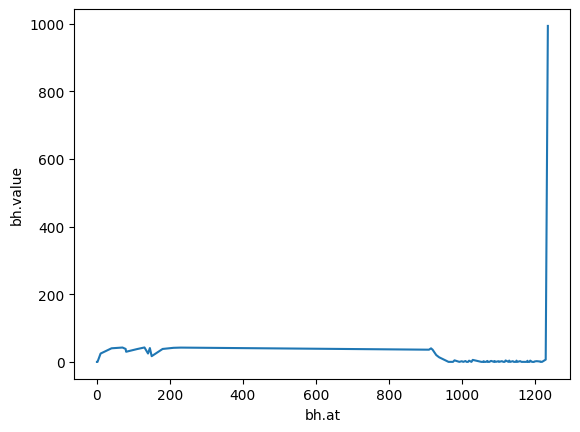

In [87]:
sns.lineplot(data=bh_df, x='bh.at', y='bh.value')

In [88]:
n = 'bwe'
k = [ { n: i } for i in sum([ i.get(n, []) for i in api_stats_qoe[1:] ], []) ]
bwe_df = pd.json_normalize(k)
bwe_df

,bwe.at,bwe.value
0,0.007,7721637
1,10.004,4169201
2,40.004,8905137
3,70.004,6988260
4,78.598,6158775
...,...,...
77,1215.828,171937
78,1216.155,171937
79,1220.004,178306
80,1230.004,178401


In [89]:
bwm_df['bwm.estimate'] = bwm_df['bwm.downloaded_bytes'] / bwm_df['bwm.seconds_to_download']

<Axes: xlabel='bwm.at', ylabel='bwm.estimate'>

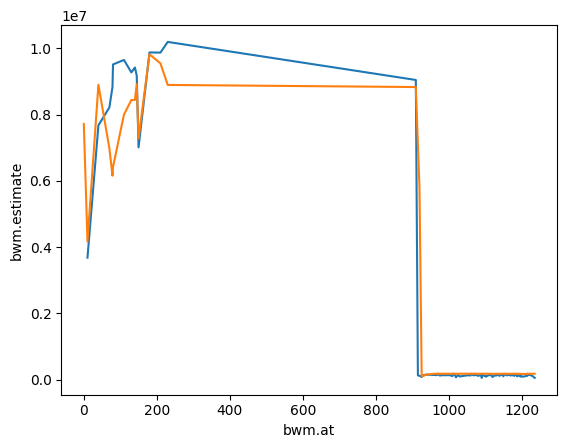

In [90]:
sns.lineplot(data=bwm_df, x='bwm.at', y='bwm.estimate')
sns.lineplot(data=bwe_df, x='bwe.at', y='bwe.value')